In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

def stimami_la_RAL(linguaggio, is_manager, istruzione, anni_esp):
    ral = 20000 # minimo
    
    # aggiungo il peso riferito al linguaggio
    ral += ral * pesi_linguaggio[linguaggio]
    
    # aggiungo il peso riferito agli anni di esperienza
    ral += ral * pesi_anni[anni_esp]
    
    # aggiungo il peso riferito al grado di istruzione
    ral += ral * pesi_istruzione[istruzione]
    
    # è un responsabile?
    if is_manager:
        ral += ral * peso_manager
    
    return ral

def calcola_stima(riga): 
    ral = stimami_la_RAL( riga['Linguaggio'], riga['Responsabile'], riga['Istruzione'], riga['Esperienza'] )
    return ral

# ----------------------
# PARAMETRI 

ALPHA = 0.04
N_ITER = 1000
MIN_RAL = 20000

# LETTURA DATAFRAME

df = pd.read_csv('DataLab_RAL.csv')

df.head(10)

# TEST PRELIMINARE

raggruppamenti = ['Linguaggio', 'Responsabile', 'Istruzione', 'Esperienza']

agg = df.groupby(raggruppamenti).agg('mean')
df_agg = agg.reset_index()
df_agg[df_agg['Linguaggio'] == 'Python']

#print(df.loc[(df['Linguaggio']=='Python') & (df['Esperienza']==2) & (df['Istruzione']=='Dottorato')])
#ral = stimami_la_RAL('Python', 0, 'Dottorato', 2)

# ----------------------


pesi_linguaggio = { 'Python': 0.05, 'Javascript': 0.01, 'Java': 0.03, 'R': 0.07, 'C#': 0.02, 
                   'Objective-C/Swift': 0.03, 'SQL': 0.02, 'COBOL': 0.04 }

pesi_istruzione = { 'Diploma': 0, 'Laurea Triennale': 0.02, 'Laurea Magistrale': 0.03, 'Dottorato': 0.05 }


def pesi_anni(anni_di_esperienza):
    if anni_di_esperienza > 8:
        return 1 
    elif 6 < anni_di_esperienza <= 8:
        return 0.7
    elif 4 < anni_di_esperienza <= 6:
        return 0.5
    elif 1 < anni_di_esperienza <= 4:
        return 0.25
    else:
        return 0

pesi_anni = {anni: pesi_anni(anni) for anni in range(1, 41)}

peso_manager = 0.5

df['Stima'] = df.apply(calcola_stima, axis=1)

# ----------------------

print(df.loc[df['Linguaggio']=='Python']) 

# Converti le colonne di stringhe in numeri

linguaggi_enc = preprocessing.LabelEncoder()
istruzione_enc = preprocessing.LabelEncoder()
linguaggi = linguaggi_enc.fit(df['Linguaggio'])
istruzione = istruzione_enc.fit(df['Istruzione'])
df['Linguaggio'] = linguaggi.transform(df['Linguaggio'])
df['Istruzione'] = istruzione.transform(df['Istruzione'])

X = df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ].values

# ----------------------------------

# Feature scaling to get a better convergence of the gradientDescent method

#avg = []
#std = []
#    avg.append(np.mean(df[elemento]))
#    std.append(np.std(df[elemento]))
#for elemento in raggruppamenti:
#    df[elemento] = (df[elemento] - np.mean(df[elemento])) / np.std(df[elemento])

#Xscal = df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ].values
#avg = np.mean(df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ]).values
#std = np.std(df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ]).values

# ----------------------------------

y = df['RAL'].values

m, n = np.shape(X)

# hypothesis function h(x) = theta0 + theta1*x1 + theta2*x2 + ...     where x0 = 1 and theta0 = 20000
X = np.concatenate((np.ones((m,1), dtype=np.int), X.reshape(m,n)), axis=1)
#Xscal = np.concatenate((np.ones((m,1), dtype=np.int), Xscal.reshape(m,n)), axis=1)
theta0 = np.ones(n+1)
theta0[0] = MIN_RAL
# GradientDescent method

# ---------------------------------

def GradientDescent(X, y, theta, m): 
    Jcycle = []
    for i in range(0, N_ITER): 
        # hypothesis function h(x) = theta*X' --> error = h(x) - y ---> Jcost = sum(err^2) / 2m
        err = np.dot(X,theta) - y
        Jcost = np.sum(err ** 2)/(2 * m)
        Jcycle.append((i, Jcost))
        grad = np.dot(X.transpose(), err) / m
        theta = theta - ALPHA * grad
    return Jcycle,theta

Jcycle, thetaGD = GradientDescent(X, y, theta0, m)

# Normal equation method ---> theta = (X.T*X)^{-1}*X.T*y [Matrix form where X.T is the transpose form of the matrix X]

# Moore-Penrose pseudo-inverse of a matrix ---> pinv = (X.T*X)^{-1}*X.T

pinv = np.linalg.pinv(X) 
thetaNE = np.dot(pinv, y)

# Similarity between the theta matrix between the two methods (i.e. thetaGD == thetaNE)

#print("The parameters evaluated with the use of the Gradient Descent method are : ",thetaGD)
#print("The parameters evaluated with the use of the Normal Equation method (exact solution) are : ",thetaNE)

# Evaluate the RAL of a new employee using the calculated theta parameters

def stima_regressione(X, theta):
    return np.dot(X,theta)

linguaggio = 5 #-avg[0]) / std[0]# Python
esperienza = 1 #- avg[1]) / std[1]
istruzione = 3 #- avg[2]) / std[2] # Laurea Triennale
responsabile = 0 #- avg[3]) / std[3]

# hypothesis function h(x) = theta0 + theta1*x1 + theta2*x2 + ...     where x0 = 1

nuovo_impiegato = [1, linguaggio, esperienza, istruzione, responsabile]

print("\n RAL for the user (Pyt,Esp=1,Trien,Res=0) using Gradient Descent : ", stima_regressione(nuovo_impiegato, thetaGD))
print("\n RAL for the user (Pyt,Esp=1,Trien,Res=0) using Normal Equation : ", stima_regressione(nuovo_impiegato, thetaNE))

   Linguaggio  Esperienza         Istruzione  Responsabile    RAL    Stima
0      Python           2            Diploma             0  24000  26250.0
2      Python           3            Diploma             0  25847  26250.0
5      Python           8          Dottorato             1  31284  56227.5
13     Python           5  Laurea Magistrale             0  30372  32445.0
23     Python           4  Laurea Magistrale             0  28382  27037.5
28     Python           6          Dottorato             0  31283  33075.0
29     Python           2          Dottorato             0  25362  27562.5
40     Python           2            Diploma             0  24954  26250.0
44     Python           7   Laurea Triennale             0  33372  36414.0
53     Python           4  Laurea Magistrale             0  27364  27037.5
58     Python           7  Laurea Magistrale             0  33287  36771.0
65     Python           7          Dottorato             1  30362  56227.5

 RAL for the user (Pyt,E

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

def stimami_la_RAL(linguaggio, is_manager, istruzione, anni_esp):
    ral = 20000 # minimo
    
    # aggiungo il peso riferito al linguaggio
    ral += ral * pesi_linguaggio[linguaggio]
    
    # aggiungo il peso riferito agli anni di esperienza
    ral += ral * pesi_anni[anni_esp]
    
    # aggiungo il peso riferito al grado di istruzione
    ral += ral * pesi_istruzione[istruzione]
    
    # è un responsabile?
    if is_manager:
        ral += ral * peso_manager
    
    return ral

def calcola_stima(riga): 
    ral = stimami_la_RAL( riga['Linguaggio'], riga['Responsabile'], riga['Istruzione'], riga['Esperienza'] )
    return ral

# ----------------------

pesi_linguaggio = { 'Python': 0.05, 'Javascript': 0.01, 'Java': 0.03, 'R': 0.07, 'C#': 0.02, 
                   'Objective-C/Swift': 0.03, 'SQL': 0.02, 'COBOL': 0.04 }

pesi_istruzione = { 'Diploma': 0, 'Laurea Triennale': 0.02, 'Laurea Magistrale': 0.03, 'Dottorato': 0.05 }


def pesi_anni(anni_di_esperienza):
    if anni_di_esperienza > 8:
        return 1 
    elif 6 < anni_di_esperienza <= 8:
        return 0.7
    elif 4 < anni_di_esperienza <= 6:
        return 0.5
    elif 1 < anni_di_esperienza <= 4:
        return 0.25
    else:
        return 0

pesi_anni = {anni: pesi_anni(anni) for anni in range(1, 41)}

peso_manager = 0.5


In [3]:
# ----------------------
# PARAMETRI 

ALPHA = 0.04
N_ITER = 1000
MIN_RAL = 20000

# LETTURA DATAFRAME

df = pd.read_csv('DataLab_RAL.csv')

# TEST PRELIMINARE

raggruppamenti = ['Linguaggio', 'Responsabile', 'Istruzione', 'Esperienza']

agg = df.groupby(raggruppamenti).agg('mean')
df_agg = agg.reset_index()
df_agg[df_agg['Linguaggio'] == 'Python']

#print(df.loc[(df['Linguaggio']=='Python') & (df['Esperienza']==2) & (df['Istruzione']=='Dottorato')])
#ral = stimami_la_RAL('Python', 0, 'Dottorato', 2)


df['Stima'] = df.apply(calcola_stima, axis=1)

# Converti le colonne di stringhe in numeri

linguaggi_enc = preprocessing.LabelEncoder()
istruzione_enc = preprocessing.LabelEncoder()
linguaggi = linguaggi_enc.fit(df['Linguaggio'])
istruzione = istruzione_enc.fit(df['Istruzione'])
df['Linguaggio'] = linguaggi.transform(df['Linguaggio'])
df['Istruzione'] = istruzione.transform(df['Istruzione'])

X = df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ].values

# ----------------------------------

# Feature scaling to get a better convergence of the gradientDescent method

#avg = []
#std = []
#    avg.append(np.mean(df[elemento]))
#    std.append(np.std(df[elemento]))
#for elemento in raggruppamenti:
#    df[elemento] = (df[elemento] - np.mean(df[elemento])) / np.std(df[elemento])

#Xscal = df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ].values
#avg = np.mean(df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ]).values
#std = np.std(df[ ['Linguaggio', 'Esperienza', 'Istruzione', 'Responsabile'] ]).values

# ----------------------------------

## Errore stima RAL --> minimizzo la Cost function J(\Theta)

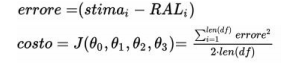 in termini matriciali
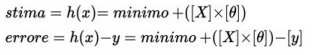

# Metodo discesa gradiente:
## 1. Assegno i pesi \Theta_0, \Theta_1, \Theta_2, \Theta_3 (e.g. partiamo da 1)
## 2. Ripeto fino a convergenza calcolando i nuovi pesi con le seguenti formule:


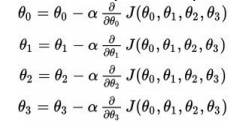

## 3. Risolvendo la derivata parziale ho la seguente formula:

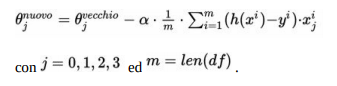

In [4]:
y = df['RAL'].values

m, n = np.shape(X)

# hypothesis function h(x) = theta0 + theta1*x1 + theta2*x2 + ...     where x0 = 1 and theta0 = 20000
X = np.concatenate((np.ones((m,1), dtype=np.int), X.reshape(m,n)), axis=1)
#Xscal = np.concatenate((np.ones((m,1), dtype=np.int), Xscal.reshape(m,n)), axis=1)
theta0 = np.ones(n+1)
theta0[0] = MIN_RAL
# GradientDescent method

# ---------------------------------

def GradientDescent(X, y, theta, m): 
    Jcycle = []
    for i in range(0, N_ITER): 
        # hypothesis function h(x) = theta*X' --> error = h(x) - y ---> Jcost = sum(err^2) / 2m
        err = np.dot(X,theta) - y
        Jcost = np.sum(err ** 2)/(2 * m)
        Jcycle.append((i, Jcost))
        grad = np.dot(X.transpose(), err) / m
        theta = theta - ALPHA * grad
    return Jcycle,theta

Jcycle, thetaGD = GradientDescent(X, y, theta0, m)

# Normal equation method ---> theta = (X.T*X)^{-1}*X.T*y [Matrix form where X.T is the transpose form of the matrix X]

# Moore-Penrose pseudo-inverse of a matrix ---> pinv = (X.T*X)^{-1}*X.T

pinv = np.linalg.pinv(X) 
thetaNE = np.dot(pinv, y)

# Similarity between the theta matrix between the two methods (i.e. thetaGD == thetaNE)

#print("The parameters evaluated with the use of the Gradient Descent method are : ",thetaGD)
#print("The parameters evaluated with the use of the Normal Equation method (exact solution) are : ",thetaNE)

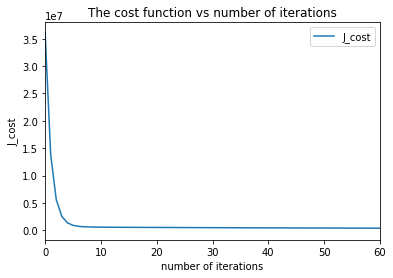

In [5]:
# J vs iterations plot

itera = [row[0] for row in Jcycle];
cost = [row[1] for row in Jcycle];
plt.plot(itera, cost, label = 'J_cost')
plt.xlim(0, 60)
plt.xlabel('number of iterations')
plt.ylabel('J_cost')
plt.title('The cost function vs number of iterations')
plt.legend(loc = 'upper right');


In [6]:
# Valutazione della RAL di un nuovo impiegato attraverso il calcolo del parametro \Theta 

def stima_regressione(X, theta):
    return np.dot(X,theta)

linguaggio = 5 #-avg[0]) / std[0]# Python
esperienza = 1 #- avg[1]) / std[1]
istruzione = 3 #- avg[2]) / std[2] # Laurea Triennale
responsabile = 0 #- avg[3]) / std[3]

# hypothesis function h(x) = theta0 + theta1*x1 + theta2*x2 + ...     where x0 = 1

nuovo_impiegato = [1, linguaggio, esperienza, istruzione, responsabile]

print("\n Calcolo RAL per l'impiegato (Pyt,Esp=1,Trien,Res=0) con il Gradient Descent Method : ", stima_regressione(nuovo_impiegato, thetaGD))
print("\n Calcolo RAL per l'impiegato (Pyt,Esp=1,Trien,Res=0) con la soluzione della Normal Equation: ", stima_regressione(nuovo_impiegato, thetaNE))


 Calcolo RAL per l'impiegato (Pyt,Esp=1,Trien,Res=0) con il Gradient Descent Method :  23328.834944244736

 Calcolo RAL per l'impiegato (Pyt,Esp=1,Trien,Res=0) con la soluzione della Normal Equation:  23320.058317098825
